# **Mental Health dataset**

## Import Libraries

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter


from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [2]:
path = "/kaggle/input/mental-health-insights-vulnerable-cancer-patients/Mental Health Dataset.csv"
df = pd.read_csv(path)
df.head()

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


In [3]:
df.shape

(10392, 3)

In [4]:
# Check for missing values
df.isna().sum()

posts        1
predicted    0
intensity    0
dtype: int64

In [5]:
df.dropna(axis = 0, inplace = True)

In [6]:
# Create a new column "Text_len" that contain the lenght of each entry
df['Text_len'] = df['posts'].apply(lambda x: len(x.split(' ')))
df.head()

,posts,predicted,intensity,Text_len
0,I know as parent of child with down syndrome t...,negative,-1,478
1,but in my heart I know this is the future prom...,neutral,0,578
2,I have mylefibrosis which turn to leukemia the...,negative,-1,456
3,from one of my health group subject wayne dyer...,neutral,0,308
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0,17


In [7]:
# Check the maximum and minmun lenght of the enteries
print( "Maximuum lenght:", max(df['Text_len']))
print("Mimum lenght:", min(df['Text_len']))

Maximuum lenght: 5413
Mimum lenght: 1


In [8]:
# Check the number of the classes in the target variable
df["predicted"].value_counts()

predicted
neutral          4374
negative         4112
very negative    1155
positive          750
Name: count, dtype: int64

## Data Preprocessing

### Data Cleaing

In [9]:
import re
import string

In [10]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [11]:
df['Text_clean'] = df['posts'].apply(clean_text)
df.head()

,posts,predicted,intensity,Text_len,Text_clean
0,I know as parent of child with down syndrome t...,negative,-1,478,i know as parent of child with down syndrome t...
1,but in my heart I know this is the future prom...,neutral,0,578,but in my heart i know this is the future prom...
2,I have mylefibrosis which turn to leukemia the...,negative,-1,456,i have mylefibrosis which turn to leukemia the...
3,from one of my health group subject wayne dyer...,neutral,0,308,from one of my health group subject wayne dyer...
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0,17,gmos now link to leukemia http nsnbc i gmo ...


### Removing Stopwords

In [12]:
from nltk.corpus import stopwords

In [13]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['Text_clean'] = df['Text_clean'].apply(remove_stopwords)
df.head()

,posts,predicted,intensity,Text_len,Text_clean
0,I know as parent of child with down syndrome t...,negative,-1,478,know parent child syndrome hear child high ris...
1,but in my heart I know this is the future prom...,neutral,0,578,heart know future promise article regardless h...
2,I have mylefibrosis which turn to leukemia the...,negative,-1,456,mylefibrosis turn leukemia want stem cell tran...
3,from one of my health group subject wayne dyer...,neutral,0,308,one health group subject wayne dyer leukemia c...
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0,17,gmos link leukemia http nsnbc gmo link leuk...


### Stemming

In [14]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [15]:
df['Text_clean'] = df['Text_clean'].apply(stemm_text)
df.head()

,posts,predicted,intensity,Text_len,Text_clean
0,I know as parent of child with down syndrome t...,negative,-1,478,know parent child syndrom hear child high risk...
1,but in my heart I know this is the future prom...,neutral,0,578,heart know futur promis articl regardless http...
2,I have mylefibrosis which turn to leukemia the...,negative,-1,456,mylefibrosi turn leukemia want stem cell trans...
3,from one of my health group subject wayne dyer...,neutral,0,308,one health group subject wayn dyer leukemia ca...
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0,17,gmos link leukemia http nsnbc gmo link leuk...


### Data Visualization

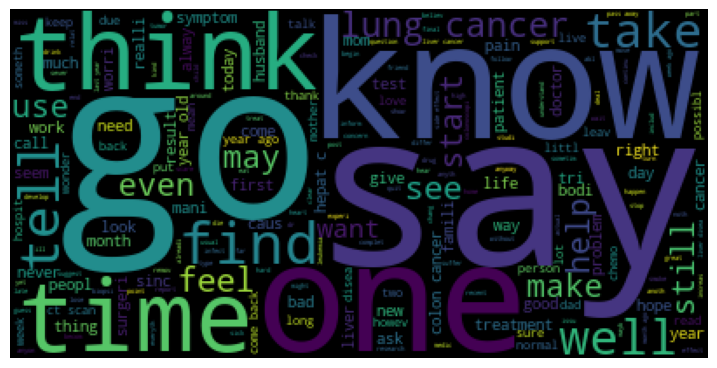

In [16]:
all_text = " ".join(df['Text_clean'])
wc = WordCloud().generate(all_text)

plt.figure(figsize = (9,6))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Tokenization

In [17]:
# Define language model
nlp = spacy.load("en_core_web_sm")

In [18]:
# Text preprocessing
def preprocess(txt:str):
    
    doc = nlp(txt)
    
    tokens_filtrered = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
            
        tokens_filtrered.append(token.lemma_)
        
    return " ".join(tokens_filtrered)

In [19]:
from nltk.tokenize import word_tokenize
df["Text_clean"] = df["Text_clean"].apply(preprocess)
df.head()

,posts,predicted,intensity,Text_len,Text_clean
0,I know as parent of child with down syndrome t...,negative,-1,478,know parent child syndrom hear child high risk...
1,but in my heart I know this is the future prom...,neutral,0,578,heart know futur promis articl regardless http...
2,I have mylefibrosis which turn to leukemia the...,negative,-1,456,mylefibrosi turn leukemia want stem cell trans...
3,from one of my health group subject wayne dyer...,neutral,0,308,health group subject wayn dyer leukemia case a...
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0,17,gmos link leukemia http nsnbc gmo link leu...


In [34]:
df["Text_clean"]

0        know parent child syndrom hear child high risk...
1        heart know futur promis articl regardless http...
2        mylefibrosi turn leukemia want stem cell trans...
3        health group subject wayn dyer leukemia case a...
4        gmos link leukemia http nsnbc     gmo link leu...
                               ...                        
10387    hey everyon   year old male work eat pretti he...
10388    surgeri stage   colon cancer   year ago cea le...
10389    doctor advis remov abnorm polyp christ size la...
10390      year old father past year realli need tri fi...
10391    bein bloodi stool sinc year start june   week ...
Name: Text_clean, Length: 10391, dtype: object

### Train-Test Split

In [22]:
SEED = 42
from sklearn.model_selection import train_test_split

X = df['Text_clean']
y = df['intensity']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED, 
                                                    stratify = y)

X_train.shape, X_test.shape

((7273,), (3118,))

### Vectorization

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# instantiate the vectorizer
vect = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect.fit(X_train)

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

In [24]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(X_train)
x_test_dtm = vect.transform(X_test)

## Modeliing

### MultinomialNB

In [25]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
model=  MultinomialNB()
model.fit(x_train_dtm, y_train)

MultinomialNB()

In [26]:
# Predictions
y_pred_train = model.predict(x_train_dtm )
y_pred_test = model.predict(x_test_dtm)

In [27]:
bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)

print(f'Balanced Accuracy Train: {bal_acc_train:.4f}')
print(f'Balanced Accuracy Test: {bal_acc_test:.4f}')

Balanced Accuracy Train: 0.5756
Balanced Accuracy Test: 0.5337


In [28]:
print("==" * 30)
print(" " * 15, "Classification Report Train")
print("==" * 30)
print(classification_report(y_train, y_pred_train))
print("")
print("==" * 30)
print(" " * 15, "Classification Report Test")
print("==" * 30)
print(classification_report(y_test, y_pred_test))

                Classification Report Train
              precision    recall  f1-score   support

          -2       0.48      0.76      0.59       808
          -1       0.59      0.61      0.60      2878
           0       0.71      0.59      0.64      3062
           1       0.37      0.34      0.35       525

    accuracy                           0.60      7273
   macro avg       0.54      0.58      0.55      7273
weighted avg       0.61      0.60      0.60      7273


                Classification Report Test
              precision    recall  f1-score   support

          -2       0.44      0.72      0.55       347
          -1       0.57      0.58      0.58      1234
           0       0.70      0.57      0.63      1312
           1       0.27      0.26      0.26       225

    accuracy                           0.57      3118
   macro avg       0.49      0.53      0.50      3118
weighted avg       0.59      0.57      0.57      3118



### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(random_state = SEED, n_jobs = -1)
rf.fit(x_train_dtm, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [30]:
# Predictions
y_pred_train = rf.predict(x_train_dtm)
y_pred_test = rf.predict(x_test_dtm )

In [31]:
from sklearn.metrics import accuracy_score
bal_acc_train = accuracy_score(y_train, y_pred_train)
bal_acc_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy Train: {bal_acc_train:.4f}')
print(f'Accuracy Test: {bal_acc_test:.4f}')

Accuracy Train: 0.9970
Accuracy Test: 0.6475


In [32]:
print("==" * 30)
print(" " * 15, "Classification Report Train")
print("==" * 30)
print(classification_report(y_train, y_pred_train))
print("")
print("==" * 30)
print(" " * 15, "Classification Report Test")
print("==" * 30)
print(classification_report(y_test, y_pred_test))

                Classification Report Train
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00       808
          -1       1.00      1.00      1.00      2878
           0       1.00      1.00      1.00      3062
           1       0.99      0.98      0.99       525

    accuracy                           1.00      7273
   macro avg       1.00      0.99      1.00      7273
weighted avg       1.00      1.00      1.00      7273


                Classification Report Test
              precision    recall  f1-score   support

          -2       0.65      0.44      0.52       347
          -1       0.59      0.74      0.66      1234
           0       0.71      0.72      0.72      1312
           1       0.68      0.08      0.14       225

    accuracy                           0.65      3118
   macro avg       0.66      0.49      0.51      3118
weighted avg       0.66      0.65      0.63      3118



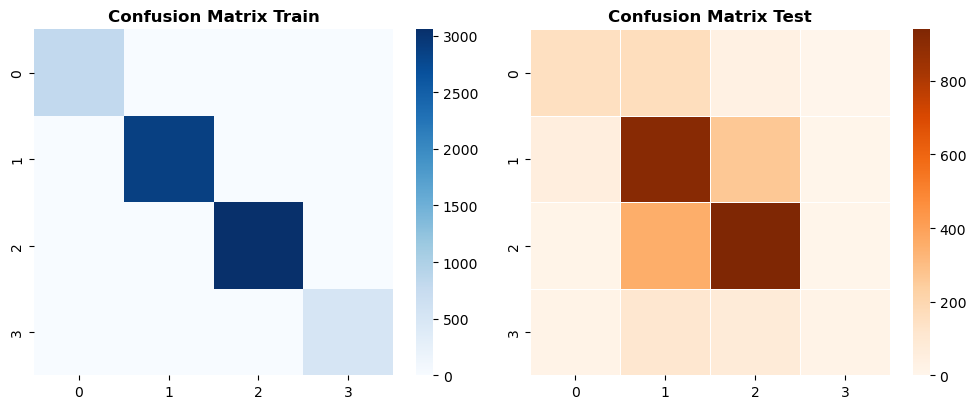

In [33]:
labels = ['very negative', 'negative', 'neutral', 'positive']

cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.2))
ax = ax.flat

sns.heatmap(cf_mx_train, fmt='', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix Train", fontsize = 12, fontweight = "bold", color = "black")

sns.heatmap(cf_mx_test, cmap='Oranges', linecolor='white', linewidths=0.5, ax=ax[1])

ax[1].set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
fig.tight_layout()
fig.show()